# Parallel k-Means clustering for distributed data analysis
**Authors**   <br>
Divari Carlo 2103360 <br>
Isotton Gloria mat 2072705 <br>
Munafò Sara mat 2072380 <br>

In [ ]:
sc.stop()
spark.stop()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import heapq
from sklearn.datasets import fetch_kddcup99
import sys
import time
import math
import csv
from pyspark.sql import SparkSession, Row
from pyspark.sql.window import Window
from pyspark.sql.functions import col, udf, min, max, sum, avg, variance, array,row_number, monotonically_increasing_id, rand, count
from pyspark.ml.feature import VectorAssembler, StandardScaler
from functools import reduce
from operator import add
from pyspark.sql.types import NumericType,DoubleType, IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA

In [2]:
spark = SparkSession.builder \
    .master("spark://10.67.22.173:7077")\
    .appName("K-means")\
    .config("spark.executor.memory", "2048m")\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
    .config("com.amazonaws.sdk.disableCertChecking","true") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/17 21:22:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

In [4]:
# create a spark context
sc = spark.sparkContext

# print its status
sc

<SparkContext master=spark://10.67.22.173:7077 appName=K-means>

In [5]:
sc.setLogLevel("ERROR")

# Abstract
Due to its simplicity, the k-means algorithm is one of the most famous machine learning algorithms used to cluster data. The main critical problem of this algorithm is that it might be blocked locally based on the initial random chosen centers. To address this issue, the k-means++ algorithm was devised, dispersing initial centers through an updated non-uniform distribution. However, K-means++ exhibits limited suitability for extensive datasets due to its inherent sequential process, necessitating k passes across the entire dataset for optimal center initialization. The `k-means||` algorithm, detailed in the "Scalable K-Means++" paper, represents a parallelized iteration of k-means++, offering improvements. Rather than sampling a single point, it oversamples multiple centers in each step while maintaining performance guarantees.

In this project our objective is to implement a parallelized `k-means||` clustering algorithm. 
This particular algorithm has demonstrated superior performance compared to other k-means algorithms, especially when dealing with large-scale datasets.
We  make use of the computational resources available in the Cloud Veneto environment along with PySpark. 
Our goal is to evaluate the performance and effectiveness of our algorithm by employing the `KDD-Cup’99` dataset.


###  Notation and Algorithm

Suppose $X = \{x_1, \dots, x_n \}$ are d-dimentional points to be clustered and k is the number of cluster (a positer integer). 

For a subset $Y \in X$, define the distance from a point $x$ to $Y$ as $d(x,Y) = min_{y \in Y} \| x-y\|$, where $\|x -y \|$denote the Euclidean distance between $x$ and $y$, define the centroid of $Y$ as
$$Centroid(Y) = \frac{1}{|Y|} \sum_{y \in Y} y$$

For a set of cluster centers $C = \{ c_1, c_2 ,\dots , c_k\}$, define the _cost of $Y$_ with respect to $C$ as:

$$ \phi_Y(C) = \sum_{y \in Y} d(y,C)^2$$

In `k-means||` algorithm, it set an oversampling factor $l = \Omega (k)$. $l>1$ is an integer.


Steps of `k-means||` initialization algorithm:

- Sample a point uniformaly from X as the first center $C$
- Compute the cost of clustering based on this choice $\phi_{X}(C)=\psi$
- for $O(log\psi)$ times repeat:  
 - Independently sample $l$ points with probability $p_{x}=\frac{l\cdot d^{2}(x,C)}{\phi_{X}(C)}$ as $C'$
 - $C=C\cup C'$
- For each point $x \in C$, compute $w_{x}$ as the number of points in $X$ closer to x than other point in $C$
- Get k clusters from reclustering those weighted points in $C$ 

# Implementation

In [6]:
kdd_10 = spark.createDataFrame(fetch_kddcup99(percent10=True,as_frame=True)['frame'])

/usr/local/spark/python/pyspark/sql/pandas/serializers.py:229: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(s.dtype):


In [7]:
kdd_10.printSchema()

root
 |-- duration: long (nullable = true)
 |-- protocol_type: binary (nullable = true)
 |-- service: binary (nullable = true)
 |-- flag: binary (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- land: long (nullable = true)
 |-- wrong_fragment: long (nullable = true)
 |-- urgent: long (nullable = true)
 |-- hot: long (nullable = true)
 |-- num_failed_logins: long (nullable = true)
 |-- logged_in: long (nullable = true)
 |-- num_compromised: long (nullable = true)
 |-- root_shell: long (nullable = true)
 |-- su_attempted: long (nullable = true)
 |-- num_root: long (nullable = true)
 |-- num_file_creations: long (nullable = true)
 |-- num_shells: long (nullable = true)
 |-- num_access_files: long (nullable = true)
 |-- num_outbound_cmds: long (nullable = true)
 |-- is_host_login: long (nullable = true)
 |-- is_guest_login: long (nullable = true)
 |-- count: long (nullable = true)
 |-- srv_count: long (nullable = true)
 |-- serror_rate: d

In [8]:
nrows=kdd_10.count()
ncols=len(kdd_10.columns)
print('Dimension of the dataset: ',nrows,'x',ncols )

Dimension of the dataset:  494021 x 42


## 1. Pre Processing

### 1.1 Remove non-numeric columns

In [9]:
#Select all columns except for the labels
data_df = kdd_10.select([col for col in kdd_10.columns if col!='labels'])

In [10]:
#Remove non-numeric columns
numeric_columns = [col_name for col_name, data_type in data_df.dtypes if data_type!='binary']
data_df = data_df.select(numeric_columns)

In [11]:
data_df.toPandas()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,181,5450,0,0,0,0,0,1,0,...,9,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0
1,0,239,486,0,0,0,0,0,1,0,...,19,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0
2,0,235,1337,0,0,0,0,0,1,0,...,29,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0
3,0,219,1337,0,0,0,0,0,1,0,...,39,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0
4,0,217,2032,0,0,0,0,0,1,0,...,49,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,310,1881,0,0,0,0,0,1,0,...,86,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0
494017,0,282,2286,0,0,0,0,0,1,0,...,6,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0
494018,0,203,1200,0,0,0,0,0,1,0,...,16,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0
494019,0,291,1200,0,0,0,0,0,1,0,...,26,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0


### 1.2 Rescale
We exploit StandardScaler method in order to rescale each column of the data so that the mean is 0.

In [12]:
feature_columns = [col for col in data_df.columns]
# Use VectorAssembler to group all feature in a single vector column:
vec_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_df = vec_assembler.transform(data_df)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=False, withMean=True)

# Compute summary statistics and generate StandardScalerModel
scalerModel = scaler.fit(assembled_df.select('features'))

# Normalize each feature to have unit standard deviation and zero mean
scaledData = scalerModel.transform(assembled_df)

In [13]:
#Transform the DF so that it only has the scaled features as columns
def extract_scale(row):
      return tuple(row.scaledFeatures.toArray().tolist())

In [14]:
data_df = scaledData.select("scaledFeatures").rdd \
        .map(extract_scale).toDF(feature_columns)

### 1.3 Apply PCA

Due to the high dimensionality of our dataset, we decide to apply a dimensionality reduction before running the tests. We select dimension 20, but later we will test how the performance of the algorithm is impacted by the reduction of the number of features of the dataset.

In [15]:
def pca_conversion(df,num_components):

    #Put all columns in one vector, this is needed to use PCA spark furnction
    assembler = VectorAssembler(inputCols=df.columns, outputCol="features")

    # Transform the DataFrame using the VectorAssembler
    df_assembled = assembler.transform(df)

    # Apply PCA to reduce dimensionality to 'num_components' principal components
    pca = PCA(k=num_components, inputCol="features", outputCol="pca_features")
    model = pca.fit(df_assembled)
    df_pca = model.transform(df_assembled)
    
    # Extract the PCA results from the DataFrame
    pca_data = df_pca.select("pca_features")

    #Put the features in a list dividing them row per row
    pca_features = pca_data.rdd.map(lambda row: row[0].toArray().tolist()).collect()

    # The number of PCA components
    num_pca_columns = len(pca_features[0]) 

    #Transform every element in the list in a row object in suche a way we can create a dataframe
    rows = [Row(pca_features=pca_feature) for pca_feature in pca_features]
    pandas_df = spark.createDataFrame(rows)

    # Create new columns for each PCA component
    for i in range(num_pca_columns):
        column_name = f"pca_{i + 1}"
        pandas_df = pandas_df.withColumn(column_name, col("pca_features")[i])
    
    # Drop the original 'pca_features' column
    pandas_df = pandas_df.drop("pca_features")

    window_spec = Window.orderBy("pca_1")

    #Put 'sample_id' as first column and we will use it as identifier
    pandas_df= pandas_df.select(row_number().over(window_spec).alias('sample_id'),'*')

    return(pandas_df)

In [16]:
data_df_red = pca_conversion(data_df,20)

In [17]:
#Check that te added identifier column is unique
data_df_red.groupBy(col('sample_id')).count().where(col('count')!=1).show()

+---------+-----+
|sample_id|count|
+---------+-----+
+---------+-----+



In [18]:
#Persist the final dataframe into memory
data_df_red.persist().count()

494021

## 2. K-means initialization algorithm

### 2.1 Cost function

In [19]:
#Define a udf to perform a sum of all selected columns in a row (will be needed in min_dist_func)
def udfSum(*cols):
    return reduce(lambda a, b: a + b, cols)
add_udf = udf(udfSum)

In [20]:
#Function to compute minimum dist from centroid and evaluating the cost
# Define the cost_func 
def cost_func(df1, df2):
    
    #Name of columns before altering
    feature_columns = [col_n for col_n in df1.columns if col_n!='sample_id']

    # Alias columns to distinguish between df1 and df2 before joining
    
    for col_name in df1.columns:
        df1 = df1.withColumnRenamed(col_name, f"data_{col_name}")
    
    for col_name in df2.columns:
        df2 = df2.withColumnRenamed(col_name, f"centroid_{col_name}")


    """ STEP 1: Perform cartesian product and compute the pairwise squared euclidean distance for each column"""
    result_df = df1.crossJoin(df2)

    diff_columns = [
        ((col(f"data_{col_name}") - col(f"centroid_{col_name}"))**2).alias(f"dist_{col_name}")
        for col_name in feature_columns
        ]
    result_df = result_df.select("data_sample_id", "centroid_sample_id", *diff_columns)


    
    """ STEP 2: To get the total distance we need to sum for each row all the columns (except the IDs) """
    
    columns_to_sum = [col_name for col_name in result_df.columns if col_name not in ['data_sample_id', 'centroid_sample_id']]
    result_df = result_df.withColumn('total_distance', add_udf(*[result_df[x] for x in columns_to_sum])) \
                         .select("data_sample_id", "centroid_sample_id", "total_distance")

    

    """ STEP 3: Find the minimum distance for each sample and sum them up """
    #Add minimum distance for each row of data_df
    window_spec = Window.partitionBy("data_sample_id")    # Create a window partitioned by "sample_id"
    min_distance_df = result_df.withColumn("min_distance", min("total_distance").over(window_spec))
                          
    cost = min_distance_df.agg(sum("min_distance")).collect()[0][0]
    
    return (min_distance_df,cost)
    

### 2.2 Random initialization

In [21]:
def base_init(df, n_clusters):
    # Sample n_clusters different points from the distinct features DataFrame
    
    centroids = df.rdd.takeSample(False, n_clusters)
    schema1 = df.columns
    centroids = spark.createDataFrame(data=centroids, schema = schema1)
   
    #sample(withReplacement=False, fraction=1.0, seed=42).limit(n_clusters)
    
    # Calculate the cost by applying the min_dist_func to each row
    _,cost = cost_func(df,centroids)

    
    return (centroids, cost)

### 2.3 k-means ++ initialization 

In [22]:
def kmeans_pp_init(df,k=10):
    
    """ Plus-plus initialization
    
    Parameters:
      df                      ndarrays data 
      k                       number of clusters
    Returns:
      "centroids"             the k centroids

    """
    
     # Randomly select the first centroid from the data points
    centroid = df.rdd.takeSample(False, 1)
    schema = df.columns
    centroids = spark.createDataFrame(data=centroid, schema = schema)
      
    for i in range(k-1):
        #For each data point compute its distance from the nearest, previously chosen centroid
        distance_df, _ = cost_func(df, centroids)
        distance_df = distance_df.withColumn("min_distance", col("min_distance").cast("float")) #to float
        distances_list = distance_df.orderBy('data_sample_id').select("min_distance").distinct().rdd.flatMap(lambda x: x).collect()  #to numpy array
        distances_array = np.array(distances_list)

        # normalize distances to get the probability of getting each point of the dataframe as new centroid
        total_distance = np.sum(distances_array)
        probabilities = distances_array / total_distance
        
        # Select the next centroid from the data points such that the probability of choosing a point as centroid is 
        # directly proportional to its distance from the nearest, previously chosen centroid.
        next_centroid_index = np.random.choice(len(probabilities), replace=False, p=probabilities)
        next_centroid = df.filter(df["sample_id"] == next_centroid_index)  
        
        # Add new centroid to the dataframe
        centroids = centroids.union(next_centroid)
        
        # Repeat to pick the remaining k-1 points ...
        
    return centroids

### 2.4 k-means || initialization

In [23]:
def parallel_init(df, k, l):
    
    """ Parallel initialization
    
    Parameters:
      df                      ndarrays data 
      k                       number of clusters
      l                       clusters sampled in each for loop
      
    Returns:
      "k_centroids"         the reclustered k centroids

    """

    # Sample a point uniformly at random from the dataframe, and assuming it as initial centroid
    centroids = df.rdd.takeSample(False, 1)
    schema = df.columns
    centroids = spark.createDataFrame(data=centroids, schema = schema)
    dist_df, current_cost = cost_func(df,centroids)
    
    
    """ Part 1: SAMPLING Log(current_cost) CENTROIDS """
    r = int(np.log10(current_cost))
    for i in range(r):
        
        dist_df = dist_df.withColumnRenamed('data_sample_id','sample_id') \
                        .drop('total_distance','centroid_sample_id').distinct()

        # Calculate the weights for each row
        dist_df = dist_df.withColumn("weight",l*col('min_distance')/current_cost).drop('min_distance')
    
        # Rescale the weights to probabilities between 0 and 1     
        distances_list = dist_df.select("weight").rdd.flatMap(lambda x: x).collect()  #to numpy array
        distances_array = np.array(distances_list)

        # normalize distances to get the probability of getting each point of the dataframe as new centroid
        total_weight = np.sum(distances_array)
        probabilities = distances_array / total_weight
        
        # Select the next centroid from the data points such that the probability of choosing a point as centroid is 
        # directly proportional to its distance from the nearest, previously chosen centroid.
        next_centroid_index = np.random.choice(len(probabilities), replace=False, p=probabilities, size=l)
        next_centroid_index = [float(x) for x in next_centroid_index]
        
        next_centroids = df.filter(col("sample_id").isin(next_centroid_index))
        
        # Add new centroid to the list and update the variable for next loop
        centroids = centroids.union(next_centroids)
        
        # Calculate the cost of assuming the initial centroid
        dist_df, current_cost = cost_func(df,centroids)
     
    
    """ Part 2: RECLUSTERING """
    min_distance_df, _ = cost_func(df,centroids)
    
    #Select first random centroid
    k_centroids = centroids.rdd.takeSample(False, 1)
    schema = centroids.columns
    k_centroids = spark.createDataFrame(data=k_centroids, schema = schema)
      
    # Filter only the rows where the distance is the minimum distance
    min_distance_df = min_distance_df.filter(col("total_distance") == col("min_distance")) 
    min_distance_df.persist().count()
    
    # Count for each centroid the number of rows for which it is the closest
    centroid_count = min_distance_df.groupBy(col("centroid_sample_id")) \
                                    .agg(count("data_sample_id").alias("weight")) \
                                    .withColumnRenamed("centroid_sample_id","sample_id")

    min_distance_df.unpersist()
    #join to get back features
    centr_tosample = centroid_count.join(centroids, 'sample_id', 'inner')
    
    #rename the id to have ordered id for sampling
    window_spec = Window.orderBy("sample_id")
    centr_tosample = centr_tosample.withColumn("sample_id", row_number().over(window_spec))
    
    # Rescale the weights to probabilities between 0 and 1     
    weights_list = centr_tosample.select("weight").rdd.flatMap(lambda x: x).collect()  #to numpy array
    weights_array = np.array(weights_list)

    # normalize distances to get the probability of getting each point of the dataframe as new centroid
    total_weight = np.sum(weights_array)
    probabilities = weights_array / total_weight
        
    # Select the next centroid from the data points such that the probability of choosing a point as centroid is 
    # directly proportional to its distance from the nearest, previously chosen centroid.
    next_centroid_index = np.random.choice(len(probabilities), replace=False, p=probabilities, size=k-1)
    next_centroid_index = [float(x) for x in next_centroid_index]
        
    next_centroids = centr_tosample.drop('weight').filter(col("sample_id").isin(next_centroid_index))

    k_centroids = k_centroids.union(next_centroids)
    
    return (k_centroids)            


## 3. Lloyd clustering algorithm

In [24]:
def KMeans(df, k, l, max_iter, break_perc, random, parallel, plusplus, \
          check_convergence, verbose): 
    
    """ Apply the KMeans clustering algorithm
    
    Parameters:
      df                          ndarrays data 
      k                           number of cluster
      r,l                         parameters for parallel init.
      max_iter                    maximum number of iterations
      break_perc                  percentage used to check convergence
      random,parallel,plusplus    if 'True' defines the initialization algorithm
      check_convergence           if 'True', stops after reaching convergence
    
    Returns:
      "cost_array"                array with cost for each iteration    
      "centroids"                 the final centroids finded by KMeans  
    """
    
    check=0
    cost_array = [] # initialize to inf so the first iteration will surely not interrupt due to convergence
    
    ## first iteration only
    if random == True:
        centroids, _ = base_init(df, k)            # Kmeans Random initial centroids
    if parallel == True:
        centroids = parallel_init(df, k, l)  # Kmeans|| initial centroids 
    if plusplus == True:
        centroids = kmeans_pp_init(df,k)           # Kmeans++ initial centroids 
            
    min_distance_df, cost = cost_func(df, centroids) # compute cost and final_df containing distances
    cost_array.append(cost) 
    iterations = 1
    
    while iterations <= max_iter:        

        ## give cluster label to each point     
        min_distance_df = min_distance_df.filter(col("total_distance") == col("min_distance"))# Filter only the rows where the distance is the minimum distance
        min_distance_df = min_distance_df.select(col("data_sample_id"), col("centroid_sample_id"), col("min_distance"))# Select only the desired columns and rename the "row_id_df2" column to 'cluster'
        min_distance_df.persist().count()
        
        ## concatenate the dataframe-with-cluster-number with kdd_99 dataframe for semplicity of application of next function
        data_df_copy = df
        data_df_copy = data_df_copy.withColumnRenamed('sample_id', 'data_sample_id') #little rename of the index col
        common_key = "data_sample_id"  
        concatenated_df = data_df_copy.join(min_distance_df, on=common_key, how="inner")

        min_distance_df.unpersist()
        ##compute new centroids
        ignored_cols = ["data_sample_id","centroid_sample_id","min_distance"]
        newCentroids = concatenated_df.groupBy("centroid_sample_id").mean().select(*[col("avg("+c+")") for c in concatenated_df.columns if c not in ignored_cols])
        centroids = newCentroids
        
        ## Use withColumnRenamed on df 'centroids' to set the new column names (without the avg)
        ignored_cols = ["data_sample_id","centroid_sample_id","min_distance"]
        new_column_names = [col_name for col_name in concatenated_df.columns if col_name not in ignored_cols]

        for old_col, new_col in zip(centroids.columns, new_column_names):
            centroids = centroids.withColumnRenamed(old_col, new_col)

        
        ## compute the cost of the new configuration of centroids
        centroids = centroids.withColumn("sample_id", monotonically_increasing_id())
        min_distance_df, newcost = cost_func(df, centroids)
        cost_array.append(newcost)
        
        ## break if the cost hasn't changed too much in the last iteration
        #if newcost > cost_array[-1]*1.3:
            #newcost = cost_array[-1]
            #cost_array.append(newcost)
        #else : 
            #cost_array.append(newcost)
        
        if verbose:
            print('Iteration number ',iterations, ', cost --> ', newcost)
            
        if check_convergence==True and check<3:
            if iterations > 0 and cost_array[-2] is not None and cost_array[-1] is not None:
                if cost_array[-1] / cost_array[-2] > break_perc:
                    check+=1
                    if check==3:
                        print('Reached convergence at iteration: ',iterations)
        
        iterations += 1
        
    return(cost_array, centroids, min_distance_df)

In [27]:
def get_clusters(min_distance_df, kdd_10):
    # Select the 'labels' and 'sample_id' columns from kdd_10
    labels = kdd_10.select('labels', 'sample_id')
    
    # Filter min_distance_df to keep only rows where 'total_distance' is equal to 'min_distance'
    min_distance_df = min_distance_df.filter(col("total_distance") == col("min_distance"))
    
    # Select only the desired columns and rename 'data_sample_id' to 'sample_id'
    min_distance_df = min_distance_df.select(col("data_sample_id"), col("centroid_sample_id"), col("min_distance"))
    min_distance_df = min_distance_df.withColumnRenamed('data_sample_id', 'sample_id')
    
    # Join min_distance_df with labels on 'sample_id' to get the actual clusters
    clusters_df = min_distance_df.join(labels, on='sample_id', how="inner")
    
    # Count the samples in each cluster
    result_df = clusters_df.groupBy("labels", "centroid_sample_id").count().orderBy("centroid_sample_id")
    
    return result_df


# Tests
- for all initializations we perform 5 Lloyd iterations, in order to compare the runtime, the cost behaviour and the number of iterations needed for convergence (for reasonable value of k, l);
- for kmeans || initialization we test the running time vs number of partitions (for reasonable value of k, l);
- for kmeans || initialization we test the performance in terms of cost and running time for different combinations of l and k;

## 1. Comparing initializations

In the first phases of testing we perform a run of Lloyd algorithm for 5 iterations.    
In this run, we test how the cost, the time, and the iterations needed to reach convergence scale with the different initialization methods.    
Since our main goal in this phase of the work is to see the comparison between methods, we use 'arbitrary' but relatively small values for the parameters, in order to reduce the computational time; specifically, we set:
- $k=15$
- $l=3$

### - Random initialization

In [29]:
#Random initialization
start = time.time()
random_cost, _, _ =  KMeans(df=data_df_red, k=15, l=3, max_iter = 5, break_perc=.98, \
                  random=True, parallel=False, plusplus=False, check_convergence=True, verbose=False) 
end = time.time()
time_rand = (end-start)
y1 = random_cost
np.savetxt("test0_rand_cost5.txt", y1)
print('Runtime for random initialization: ',time_rand)

Reached convergence at iteration:  3


Runtime for random initialization:  759.5717377662659


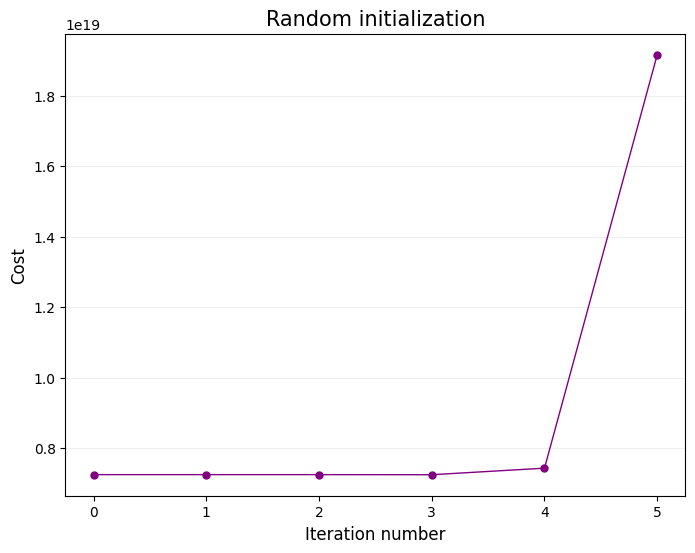

In [30]:
#Plot
x = np.arange(0,len(y1))

plt.figure(figsize=(8, 6))
plt.plot(x, y1, label='Random initialization', linestyle='-', marker='o', markersize=5, color='purple', lw=1)
plt.title("Random initialization",fontsize=15)
plt.xlabel('Iteration number', fontsize=12)
plt.ylabel('Cost', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.2)
plt.show()

### - K-means++ initialization

In [31]:
#K-means++ initialization
start = time.time()
plusplus_cost, _, _ =  KMeans(df=data_df_red, k=15, l=3, max_iter = 5, break_perc=.98, \
                  random=False, parallel=False, plusplus=True, check_convergence=True, verbose=False) 
end = time.time()
time_pp = (end-start)
y2 = plusplus_cost
np.savetxt("test0_pp_cost.txt", y2)
print('Runtime for kmeans++ initialization: ',time_pp)

Reached convergence at iteration:  4


Runtime for kmeans++ initialization:  993.4863095283508


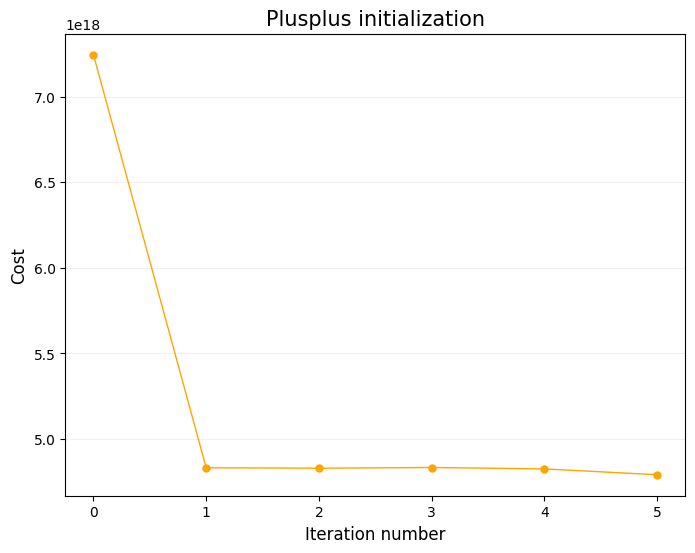

In [32]:
#Plot
x = np.arange(0,len(y2))

plt.figure(figsize=(8, 6))
plt.plot(x, y2, label='Plusplus initialization', linestyle='-', marker='o', markersize=5, color='orange', lw=1)
plt.title("Plusplus initialization",fontsize=15)
plt.xlabel('Iteration number', fontsize=12)
plt.ylabel('Cost', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.2)
plt.show()

### - K-means// initialization

In [33]:
#K-means //
start = time.time()
par_cost, _, _ =  KMeans(df=data_df_red, k=15, l=3, max_iter = 5, break_perc=.98, \
                  random=False, parallel=True, plusplus=False, check_convergence=True, verbose=False) 
end = time.time()
time_par = (end-start)
y3 = par_cost
np.savetxt("test0_par_cost.txt", y3)
print('Runtime for kmeans// initialization: ',time_par)

Reached convergence at iteration:  3


Runtime for kmeans// initialization:  2031.0286881923676


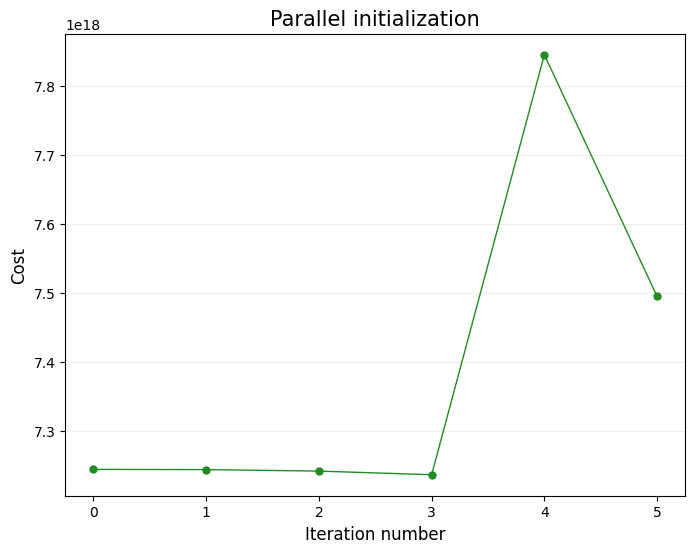

In [34]:
#Plot
x = np.arange(0,len(y3))

plt.figure(figsize=(8, 6))
plt.plot(x, y3, label='Parallel initialization', linestyle='-', marker='o', markersize=5, color='forestgreen', lw=1)
plt.title("Parallel initialization",fontsize=15)
plt.xlabel('Iteration number', fontsize=12)
plt.ylabel('Cost', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.2)
plt.show()

### $\bullet$ Comparing performances

In [35]:
times = [[ 759.5717377662659,993.4863095283508,2031.0286881923676]]
times_df = pd.DataFrame(times, columns=['random', 'plusplus', 'parallel'])
print('Time(s) for different initializations: ')
times_df

Time(s) for different initializations: 


,random,plusplus,parallel
0,759.571738,993.48631,2031.028688


The results obtained suggest that the Random initialization is faster than the Parallel initialization; we could compare the final cost and notice that the cost after the parallel initialization is lower that the one after the random initialization, however, the behaviour of the cost in all cases suggests that the number of iterations of Lloyd performed are too low to reach convergence and therefore to have a significative estimate of the cost.    
We see a peak both in the random and parallel case, which leads us to believe that the algorithm is far from convergence and that our convergence condition is too 'weak'. To really perform an efficient comparison between the methods, we should test the algorithm for a larger number of iterations, but due to the computational time of our algorithm and the network instability we were not able to do so.

## 2. Run time vs number of partitions

In [ ]:
partitions = [8, 16, 64]
parallel_part = []

#k = 15
#iter_avg = 5

for i, n_parts in enumerate(partitions):
    print(f"Working with {n_parts} partitions")
    kdd_repart = data_df_red.repartition(n_parts).persist()
    kdd_repart.count()
    
    #parallel
    start = time.time()
    _, _, _ =  KMeans(df=kdd_repart, k=15, l=3, max_iter = 5, break_perc=.98, \
                  random=False, parallel=True, plusplus=False, check_convergence=True, verbose=False)
    end = time.time()
    parallel_part.append((end - start))
    print(f"Parallel init done in {end - start} s")
    
    kdd_repart.unpersist()
        
# save to file
np.savetxt("parallel_part.txt", parallel_part)


Working with 8 partitions


Reached convergence at iteration:  3


Parallel init done in 3911.6796283721924 s
Working with 16 partitions


Reached convergence at iteration:  3


Parallel init done in 7231.708043575287 s
Working with 64 partitions


In [37]:
partitions = [4]
parallel_part = []


for i, n_parts in enumerate(partitions):
    print(f"Working with {n_parts} partitions")
    kdd_repart = data_df_red.repartition(n_parts).persist()
    kdd_repart.count()
    
    #parallel
    start = time.time()
    _, _, _ =  KMeans(df=kdd_repart, k=15, l=3, max_iter = 5, break_perc=.98, \
                  random=False, parallel=True, plusplus=False, check_convergence=True, verbose=False)
    end = time.time()
    parallel_part.append((end - start))
    print(f"Parallel init done in {end - start} s")
    
    kdd_repart.unpersist()
        
# save to file
np.savetxt("parallel_part_4.txt", parallel_part)

Working with 4 partitions


Reached convergence at iteration:  3


Parallel init done in 2752.6009624004364 s


### $\bullet$ Comparing results

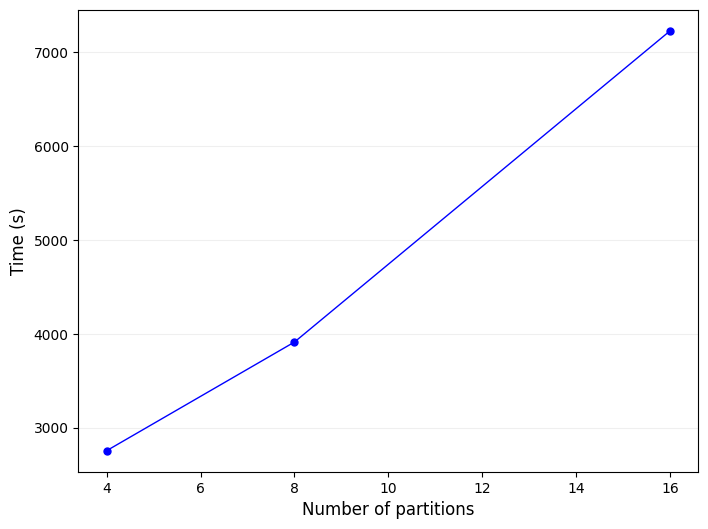

In [38]:
#Parallel initialization
x = [4,8,16]
y = [2752.6009624004364,3911.6796283721924,7231.708043575287]

plt.figure(figsize=(8, 6))
plt.plot(x, y, linestyle='-', marker='o', markersize=5, color='blue',lw=1)
plt.xlabel('Number of partitions', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.2)
plt.show()

Due to network stability problems we were not able to test the algorithm with a higher number of partitions, the result obtained however suggest that we would not have obtained a parabolic (or a decreasing) behaviour. We see, in fact, a rising trend, proportional to the number of partitions used; this might suggest that the parallel algorithm we implemented is not sufficiently parallelized.    
If the parallelization is optimal, in fact, we should expect the runtime to decreas with the number of partitions, untili it reaches a minimum, and then to start rising again.

## 3. Cost varying the algorithm 

After selecting the optimal number of partitions, we proceed with the observation of the performance of the algorithm varying its parameters $k$ and $l$. Specifically, we set $l\sim 0.25k$ for each $k$:
- $k=20$, $l=5$
- $k=30$, $l=7$
- $k=50$, $l=12$

In [39]:
#data repartitioned
kdd_repart = data_df_red.repartition(4).persist()
kdd_repart.count()

#unpersist old df
data_df_red.unpersist()

DataFrame[sample_id: int, pca_1: double, pca_2: double, pca_3: double, pca_4: double, pca_5: double, pca_6: double, pca_7: double, pca_8: double, pca_9: double, pca_10: double, pca_11: double, pca_12: double, pca_13: double, pca_14: double, pca_15: double, pca_16: double, pca_17: double, pca_18: double, pca_19: double, pca_20: double]

### $\bullet \quad k=20$

In [40]:
# k=20
result_data_P = []

# Test parameters
k = 20
l = 5
max_iterations = 5
seed = []
final = []

    
# Run KMeans with parallel initialization 
start = time.time()
parallel_cost, _, _ =  KMeans(df=kdd_repart, k=20, l=5, max_iter = 5, break_perc=.98, \
                  random=False, parallel=True, plusplus=False, check_convergence=False, verbose=False)
end = time.time()
seed.append(parallel_cost[1])
final.append(parallel_cost[-1])
        
    # Append results to the data list
result_data_P.append(("Parallel", k, l, np.mean(seed),np.mean(final),(end-start)))

#save
result_schema = ["Initialization","K", "l", "Init_cost", "Final_cost", "Time"]
result_data_P = pd.DataFrame(result_data_P, columns=result_schema)
result_data_P.to_csv('Cost_parallel_k_20.txt', sep='\t', index=False)

### $\bullet \quad k=30$

In [ ]:
# k=30
result_data_P = []

# Test parameters
k = 30
l = 7
max_iterations = 5
seed = []
final = []

    
# Run KMeans with parallel initialization 
start = time.time()
parallel_cost, _, _ =  KMeans(df=kdd_repart, k=30, l=7, max_iter = 5, break_perc=.98, \
                  random=False, parallel=True, plusplus=False, check_convergence=False, verbose=False)
end = time.time()
seed.append(parallel_cost[1])
final.append(parallel_cost[-1])
        
# Append results to the data list
result_data_P.append(("Parallel", k, l, np.mean(seed),np.mean(final),(end-start)))

#save
result_schema = ["Initialization","K", "l", "Init_cost", "Final_cost", "Time"]
result_data_P = pd.DataFrame(result_data_P, columns=result_schema)
result_data_P.to_csv('Cost_parallel_k_30.txt', sep='\t', index=False)

### $\bullet \quad  k=50$

In [42]:
# Parallel Initialization
result_data_P = []

# Test parameters
k = 50
l = 12
max_iterations = 5
seed = []
final = []

    
# Run KMeans with parallel initialization 
start = time.time()
parallel_cost, _, _ =  KMeans(df=kdd_repart, k=50, l=12, max_iter = 5, break_perc=.98, \
                  random=False, parallel=True, plusplus=False, check_convergence=False, verbose=False)
end = time.time()
seed.append(parallel_cost[1])
final.append(parallel_cost[-1])
        
# Append results to the data list
result_data_P.append(("Parallel", k, l, np.mean(seed),np.mean(final),(end-start)))

#save
result_schema = ["Initialization","K", "l", "Init_cost", "Final_cost", "Time"]
result_data_P = pd.DataFrame(result_data_P, columns=result_schema)
result_data_P.to_csv('Cost_parallel_k_50.txt', sep='\t', index=False)

### $\bullet$ Comparing results

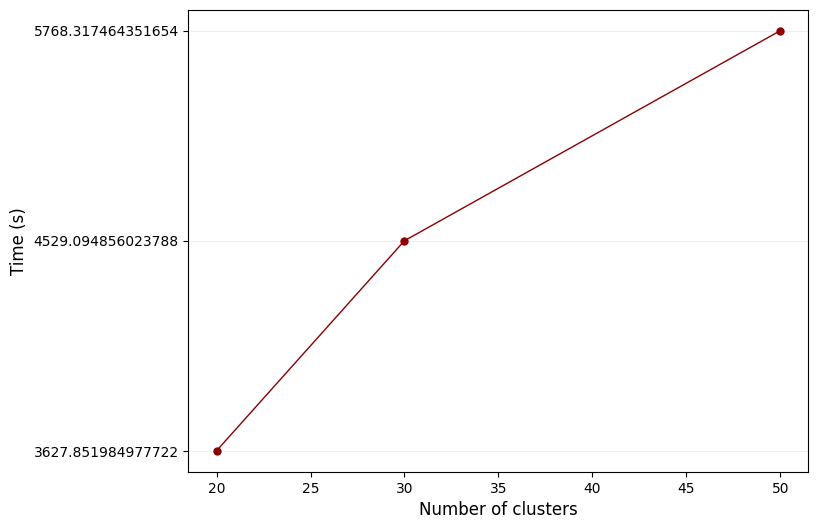

In [43]:
y = []
with open('Cost_parallel_k_20.txt', 'r') as file:
    csv_reader = csv.reader(file, delimiter='\t') 
    next(csv_reader, None)
    for row in csv_reader:
        time = row[-1]
        y.append(time)
with open('Cost_parallel_k_30.txt', 'r') as file:
    csv_reader = csv.reader(file, delimiter='\t') 
    next(csv_reader, None)
    for row in csv_reader:
        time = row[-1]
        y.append(time)
with open('Cost_parallel_k_50.txt', 'r') as file:
    csv_reader = csv.reader(file, delimiter='\t') 
    next(csv_reader, None)
    for row in csv_reader:
        time = row[-1]
        y.append(time)
x = [20,30,50]

plt.figure(figsize=(8, 6))
plt.plot(x, y, linestyle='-', marker='o', markersize=5, color='darkred',lw=1)
plt.xlabel('Number of clusters', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.2)
plt.show()

# PCA: Dimensionality reduction test

In this last part of the project, we focus on the dimensionality reduction performed at the beginning of our work (from $n\_cols=39$ to $n\_cols=20$. We want to compute the accuracy of this dimensionality reduction, comparing it with the performance of the algorithm on the whole dataset; for a more detailed comparison, we also computed the accuracy for dimensionality reductions to lower dimensions ($n\_cols=15$ and $n\_cols=10$).

In [44]:
n_partitions=4

### $\bullet \quad N°components=20$

In [45]:
kdd_data_20 = data_df_red.repartition(n_partitions)
kdd_data_20.persist().count()

494021

In [46]:
start = time.time()
#K-means //
start = time.time()
par_cost20, cen_20, min_df20 =  KMeans(df=kdd_data_20, k=20, l=5, max_iter = 5, break_perc=.98, \
                  random=False, parallel=True, plusplus=False, check_convergence=False, verbose=False) 
end = time.time()
time_par20 = (end-start)
y_20 = par_cost20

#Save results
np.savetxt("test_par_cost_pca20.txt", y_20)
cen_20.coalesce(1)\
    .write.option('header','true')\
    .option('sep',',')\
    .mode('overwrite')\
    .csv('test_cen_pca20')

NameError: name 'min_df_20' is not defined

In [47]:
min_df20.coalesce(1)\
    .write.option('header','true')\
    .option('sep',',')\
    .mode('overwrite')\
    .csv('test_min_df20_pca20')

print('Runtime for kmeans// initialization (dimension=20): ',time_par20)

Runtime for kmeans// initialization (dimension=20):  3148.354257106781


In [48]:
kdd_data_20.unpersist()

DataFrame[sample_id: int, pca_1: double, pca_2: double, pca_3: double, pca_4: double, pca_5: double, pca_6: double, pca_7: double, pca_8: double, pca_9: double, pca_10: double, pca_11: double, pca_12: double, pca_13: double, pca_14: double, pca_15: double, pca_16: double, pca_17: double, pca_18: double, pca_19: double, pca_20: double]

In [49]:
data_df_red.unpersist()

DataFrame[sample_id: int, pca_1: double, pca_2: double, pca_3: double, pca_4: double, pca_5: double, pca_6: double, pca_7: double, pca_8: double, pca_9: double, pca_10: double, pca_11: double, pca_12: double, pca_13: double, pca_14: double, pca_15: double, pca_16: double, pca_17: double, pca_18: double, pca_19: double, pca_20: double]

### $\bullet \quad N°components=39$: Complete dataset

In [51]:
window_spec = Window.orderBy("duration")
data_df = data_df.withColumn("sample_id", row_number().over(window_spec))

In [52]:
#Check that te added identifier column is unique
data_df.groupBy(col('sample_id')).count().where(col('count')!=1).show()

+---------+-----+
|sample_id|count|
+---------+-----+
+---------+-----+



In [53]:
kdd_data_tot = data_df.repartition(n_partitions)
kdd_data_tot.persist().count()

494021

In [54]:
start = time.time()
#K-means //
start = time.time()
par_cost_tot, cen_tot, min_df_tot =  KMeans(df=kdd_data_tot, k=20, l=5, max_iter = 5, break_perc=.98, \
                  random=False, parallel=True, plusplus=False, check_convergence=False, verbose=False) 
end = time.time()
time_par_tot = (end-start)
y_tot = par_cost_tot

#Save results
np.savetxt("test_par_cost_pca_tot.txt", y_tot)
cen_tot.coalesce(1)\
    .write.option('header','true')\
    .option('sep',',')\
    .mode('overwrite')\
    .csv('test_cen_pca_tot')
min_df_tot.coalesce(1)\
    .write.option('header','true')\
    .option('sep',',')\
    .mode('overwrite')\
    .csv('test_min_df_pca_tot')

print('Runtime for kmeans// initialization (Total dataset): ',time_par_tot)

Runtime for kmeans// initialization (Total dataset):  4659.715532064438


In [55]:
kdd_data_tot.unpersist()

DataFrame[duration: double, src_bytes: double, dst_bytes: double, land: double, wrong_fragment: double, urgent: double, hot: double, num_failed_logins: double, logged_in: double, num_compromised: double, root_shell: double, su_attempted: double, num_root: double, num_file_creations: double, num_shells: double, num_access_files: double, num_outbound_cmds: double, is_host_login: double, is_guest_login: double, count: double, srv_count: double, serror_rate: double, srv_serror_rate: double, rerror_rate: double, srv_rerror_rate: double, same_srv_rate: double, diff_srv_rate: double, srv_diff_host_rate: double, dst_host_count: double, dst_host_srv_count: double, dst_host_same_srv_rate: double, dst_host_diff_srv_rate: double, dst_host_same_src_port_rate: double, dst_host_srv_diff_host_rate: double, dst_host_serror_rate: double, dst_host_srv_serror_rate: double, dst_host_rerror_rate: double, dst_host_srv_rerror_rate: double, sample_id: int]

### $\bullet \quad N°components=15$

In [56]:
data_df_15 = pca_conversion(data_df,15)
kdd_data_15= data_df_15.repartition(n_partitions)
kdd_data_15.persist().count()

494021

In [57]:
start = time.time()
#K-means //
start = time.time()
par_cost15, cen_15, min_df15 =  KMeans(df=kdd_data_15, k=20, l=5, max_iter = 5, break_perc=.98, \
                  random=False, parallel=True, plusplus=False, check_convergence=False, verbose=False) 
end = time.time()
time_par15 = (end-start)
y_15 = par_cost15

#Save results
np.savetxt("test_par_cost_pca15.txt", y_15)
cen_15.coalesce(1)\
    .write.option('header','true')\
    .option('sep',',')\
    .mode('overwrite')\
    .csv('test_cen_pca15')
min_df15.coalesce(1)\
    .write.option('header','true')\
    .option('sep',',')\
    .mode('overwrite')\
    .csv('test_min_df15_pca15')

print('Runtime for kmeans// initialization (dimension=15): ',time_par15)

Runtime for kmeans// initialization (dimension=15):  3280.339277744293


In [58]:
kdd_data_15.unpersist()

DataFrame[sample_id: int, pca_1: double, pca_2: double, pca_3: double, pca_4: double, pca_5: double, pca_6: double, pca_7: double, pca_8: double, pca_9: double, pca_10: double, pca_11: double, pca_12: double, pca_13: double, pca_14: double, pca_15: double]

### $\bullet \quad N°components=10$

In [59]:
data_df_10 = pca_conversion(data_df,10)
kdd_data_10= data_df_10.repartition(n_partitions)
kdd_data_10.persist().count()

494021

In [60]:
start = time.time()
#K-means //
start = time.time()
par_cost10, cen_10, min_df10 =  KMeans(df=kdd_data_10, k=20, l=5, max_iter = 5, break_perc=.98, \
                  random=False, parallel=True, plusplus=False, check_convergence=False, verbose=False) 
end = time.time()
time_par10 = (end-start)
y_10 = par_cost10

#Save results
np.savetxt("test_par_cost_pca10.txt", y_10)
cen_10.coalesce(1)\
    .write.option('header','true')\
    .option('sep',',')\
    .mode('overwrite')\
    .csv('test_cen_pca10')
min_df10.coalesce(1)\
    .write.option('header','true')\
    .option('sep',',')\
    .mode('overwrite')\
    .csv('test_min_df10_pca10')

print('Runtime for kmeans// initialization (dimension=10): ',time_par10)

Runtime for kmeans// initialization (dimension=10):  2567.441884994507


In [61]:
kdd_data_10.unpersist()

DataFrame[sample_id: int, pca_1: double, pca_2: double, pca_3: double, pca_4: double, pca_5: double, pca_6: double, pca_7: double, pca_8: double, pca_9: double, pca_10: double]

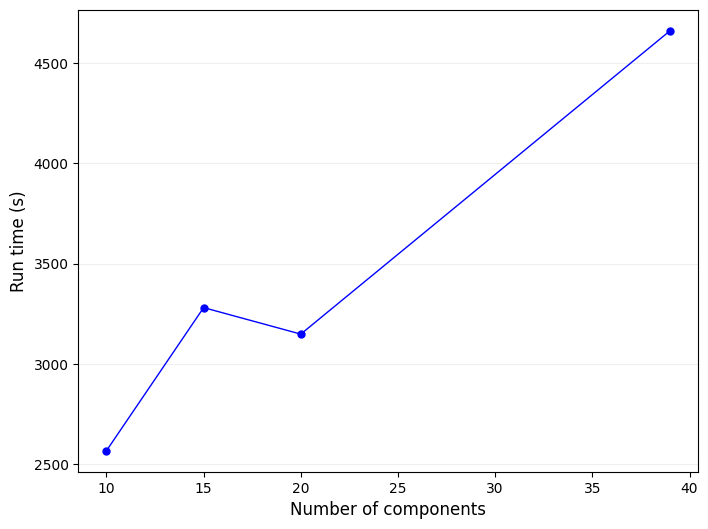

In [62]:
times = [4659.715532064438, 3148.354257106781, 3280.339277744293, 2567.441884994507]
num_components = [39, 20, 15, 10]

plt.figure(figsize=(8, 6))
plt.plot(num_components, times, linestyle='-', marker='o', markersize=5, color='blue',lw=1)
plt.xlabel('Number of components', fontsize=12)
plt.ylabel('Run time (s)', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.2)
plt.show()

# $\bullet \quad$ PCA feature selection comparison: tradeoff

In [63]:
#add sample_id column to kdd_10 in such a way we are able to use the function
#we defined as get_clusters
window_spec = Window.orderBy("duration")
kdd_10_1 = kdd_10.withColumn("sample_id", row_number().over(window_spec))

def find_label_centroid(df):
    '''
    Input: output of the function get clusters
    Output: for each centroid_sample_id the labels which is most represented and its count
    '''
    window_spec = Window.partitionBy("centroid_sample_id").orderBy(col("count").desc())
    result_df = df.withColumn("max_count", max("count").over(window_spec))
    result_df = result_df.filter(result_df["count"] == result_df["max_count"]).drop("max_count")

    return result_df

Load data, apply get_clusters function and find_label_centroid function.


In [64]:
#read file output of Kmeans applied to pca with 20 components
min_df_20 = pd.read_csv('test_min_df20_pca20/test_min_df20_pca_20.csv')
min_df_20 = spark.createDataFrame(min_df_20)

result_20 = get_clusters(min_df_20,kdd_10_1)
predict_20 = find_label_centroid(result_20)
predict_20.persist().count()

/usr/local/spark/python/pyspark/sql/pandas/serializers.py:229: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(s.dtype):


19

In [65]:
predict_20.show()

+-------------------+------------------+------+
|             labels|centroid_sample_id| count|
+-------------------+------------------+------+
|[73 6D 75 72 66 2E]|                 0|121548|
|[73 6D 75 72 66 2E]|                 1|133630|
|[73 6D 75 72 66 2E]|                 2|133630|
|[73 6D 75 72 66 2E]|                 3|  2701|
|[73 6D 75 72 66 2E]|                 4|  3883|
|[73 6D 75 72 66 2E]|                 5|  1947|
|[73 6D 75 72 66 2E]|                 6|  2710|
|[73 6D 75 72 66 2E]|                 7|  3857|
|[73 6D 75 72 66 2E]|                 8|121548|
|[73 6D 75 72 66 2E]|                 9|  2701|
|[73 6D 75 72 66 2E]|                10|  3206|
|[73 6D 75 72 66 2E]|                11|   469|
|[73 6D 75 72 66 2E]|                12|  2701|
|[73 6D 75 72 66 2E]|                13|  1657|
|[73 6D 75 72 66 2E]|                14|133630|
|[73 6D 75 72 66 2E]|                15|  1293|
|[73 6D 75 72 66 2E]|                16|  2710|
|[73 6D 75 72 66 2E]|                17|

In [66]:
predict_20.unpersist()

DataFrame[labels: binary, centroid_sample_id: bigint, count: bigint]

In [67]:
#read file output of Kmeans applied to pca with 15 components
min_df_15 = pd.read_csv('test_min_df15_pca15/test_min_df15_pca_15.csv')
min_df_15 = spark.createDataFrame(min_df_15)

result_15 = get_clusters(min_df_15,kdd_10_1)
predict_15 = find_label_centroid(result_15)
predict_15.persist().count()

/usr/local/spark/python/pyspark/sql/pandas/serializers.py:229: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(s.dtype):


20

In [68]:
predict_15.show()

+--------------------+------------------+------+
|              labels|centroid_sample_id| count|
+--------------------+------------------+------+
| [73 6D 75 72 66 2E]|                 0|  5632|
| [73 6D 75 72 66 2E]|                 1|  5632|
| [73 6D 75 72 66 2E]|                 2|  5632|
| [73 6D 75 72 66 2E]|                 3|  5632|
| [73 6D 75 72 66 2E]|                 4|  5632|
| [73 6D 75 72 66 2E]|                 5| 68449|
| [73 6D 75 72 66 2E]|                 6|  5632|
| [73 6D 75 72 66 2E]|                 7|  5632|
| [73 6D 75 72 66 2E]|                 8|  5632|
| [73 6D 75 72 66 2E]|                 9|  5632|
|[6E 6F 72 6D 61 6...|                10|   390|
| [73 6D 75 72 66 2E]|                11|  5632|
| [73 6D 75 72 66 2E]|                12|172134|
| [73 6D 75 72 66 2E]|                13|  5632|
| [73 6D 75 72 66 2E]|                14|  5632|
| [73 6D 75 72 66 2E]|                15|  5632|
| [73 6D 75 72 66 2E]|                16|  1565|
| [73 6D 75 72 66 2E

In [69]:
predict_15.unpersist()

DataFrame[labels: binary, centroid_sample_id: bigint, count: bigint]